### Setting up the environment

In [3]:
import pickle
import pandas as pd
import sys
import numpy as np
import os
import tensorflow 
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, LSTM, RNN, Bidirectional, Flatten, Activation, \
    RepeatVector, Permute, Multiply, Lambda, Concatenate, BatchNormalization
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import TimeDistributed, GRU
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import RMSprop, Adagrad
from transformers import TFBertModel
from tensorflow.keras.layers import SpatialDropout1D
from transformers import TFBertForSequenceClassification, BertConfig
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import f1_score, recall_score, precision_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score, matthews_corrcoef
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score, auc, roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [4]:
seed_value = 42
#seed_value = None

np.random.seed(seed_value)
random.seed(seed_value)
tensorflow.random.set_seed(seed_value)

environment_name = sys.executable.split('/')[-3]
print('Environment:', environment_name)
os.environ[environment_name] = str(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import tensorflow.compat.v1.keras.backend as K
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

Environment: biotmpygpu


2024-06-06 18:25:58.572434: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9586 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1e:00.0, compute capability: 7.5
2024-06-06 18:25:58.576185: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9524 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3d:00.0, compute capability: 7.5
2024-06-06 18:25:58.579401: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 9804 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3f:00.0, compute capability: 7.5
2024-06-06 18:25:58.582984: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 9804 MB memory:  -> device: 3, name: NVIDIA GeForce RTX

In [3]:
!nvidia-smi

Fri May 24 15:48:34 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     Off | 00000000:1E:00.0 Off |                  N/A |
| 32%   38C    P2              52W / 250W |    159MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
select_gpus = [0]
#select_gpus = None 

In [6]:
import os
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

if select_gpus:
    devices = []
    for gpu in select_gpus:
        devices.append('/gpu:' + str(gpu))    
    strategy = tensorflow.distribute.MirroredStrategy(devices=devices)
    os.environ["CUDA_VISIBLE_DEVICES"] = ''

else:
    
    device_name = tensorflow.test.gpu_device_name()
    if device_name == '/device:GPU:0':
        print('Using GPU: {}'.format(device_name))
    else:
        raise SystemError('GPU device not found')

    os.environ["CUDA_VISIBLE_DEVICES"] = device_name
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

Num GPUs Available:  8
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


2024-06-06 18:26:02.534632: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9586 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1e:00.0, compute capability: 7.5
2024-06-06 18:26:02.535758: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9524 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3d:00.0, compute capability: 7.5
2024-06-06 18:26:02.536802: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 9804 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3f:00.0, compute capability: 7.5
2024-06-06 18:26:02.537845: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 9804 MB memory:  -> device: 3, name: NVIDIA GeForce RTX

# DAVIS

### Dataset Loading

In [6]:
Davis= pd.read_csv('/home/resperanca/Projeto/data/Davis.csv')
Davis= Davis.drop_duplicates()
colunas = ['COMPOUND_SMILES', 'PROTEIN_SEQUENCE', 'REG_LABEL']  
Davis = Davis.dropna(subset=colunas)
limite = 7
Davis['REG_LABEL'] = Davis['REG_LABEL'].apply(lambda x: 1 if x > limite else 0)
Davis= Davis.sample(frac=1).reset_index(drop=True)
Davis.to_csv('Davis_final.csv', index=False, encoding='utf-8')


In [7]:
Davis= pd.read_csv('/home/resperanca/Projeto/DeepDTA/Davis_final.csv')

In [8]:
#Filtragem por tamanho (proteinas): 

tamanho_proteinas = Davis['PROTEIN_SEQUENCE']
tamanho_proteinas = [len(seq) for seq in tamanho_proteinas]
tamanho_medio_prot = sum(tamanho_proteinas) / len(tamanho_proteinas)


#Filtragem por tamanho (Smiles): 

tamanho_smiles = Davis['COMPOUND_SMILES']
tamanho_smiles = [len(seq) for seq in tamanho_smiles]
tamanho_medio_smiles = sum(tamanho_smiles) / len(tamanho_smiles)

### Encoding inputs

In [7]:
CHAR_PROT_SET = { "A": 1, "C": 2, "B": 3, "E": 4, "D": 5, "G": 6,
				"F": 7, "I": 8, "H": 9, "K": 10, "M": 11, "L": 12,
				"O": 13, "N": 14, "Q": 15, "P": 16, "S": 17, "R": 18,
				"U": 19, "T": 20, "W": 21,
				"V": 22, "Y": 23, "X": 24,
				"Z": 25 }

CHAR_SMILE_SET = {"#": 29, "%": 30, ")": 31, "(": 1, "+": 32, "-": 33, "/": 34, 
                 ".": 2, "1": 35, "0": 3, "3": 36, "2": 4, "5": 37, "4": 5, 
                 "7": 38, "6": 6, "9": 39, "8": 7, "=": 40, "A": 41, "@": 8, "C": 42, "B": 9, "E": 43, 
                 "D": 10, "G": 44, "F": 11, "I": 45, "H": 12, "K": 46, "M": 47, "L": 13, 
                 "O": 48, "N": 14, "P": 15, "S": 49, "R": 16, "U": 50, "T": 17, "W": 51, 
                 "V": 18, "Y": 52, "[": 53, "Z": 19, "]": 54, "\\": 20, "a": 55, "c": 56, 
                 "b": 21, "e": 57, "d": 22, "g": 58, "f": 23, "i": 59, "h": 24, "m": 60, 
                 "l": 25, "o": 61, "n": 26, "s": 62, "r": 27, "u": 63, "t": 28, "y": 64, '*':65}

In [8]:
PROT_LEN = 703
SMILE_LEN = 60


def label_smiles(line, MAX_SMI_LEN, CHAR_SMILE_SET):
	X = np.zeros(MAX_SMI_LEN)
	for i, ch in enumerate(line[:MAX_SMI_LEN]): #	x, smi_ch_ind, y
		X[i] = CHAR_SMILE_SET[ch]

	return X #.tolist()

def label_sequence(line, MAX_SEQ_LEN, CHAR_PROT_SET):
	X = np.zeros(MAX_SEQ_LEN)

	for i, ch in enumerate(line[:MAX_SEQ_LEN]):
		X[i] = CHAR_PROT_SET[ch]

	return X #.tolist()

In [1]:
encoded_data_Davis = {'x_prot':[], 'x_met':[], 'y_train':[]}

for i, (index, row) in enumerate(Davis.iterrows()):
     print('percentage: {0:.3%}'.format(i/Davis.shape[0]), end='\r')
     encoded_data_Davis['x_prot'].append(label_sequence(row['PROTEIN_SEQUENCE'], PROT_LEN, CHAR_PROT_SET))
     encoded_data_Davis['x_met'].append(label_smiles(row['COMPOUND_SMILES'], SMILE_LEN, CHAR_SMILE_SET))
     encoded_data_Davis['y_train'].append(row['REG_LABEL'])

### Spliting data

In [11]:
total_samples = 26000


train_size = int(0.7 * total_samples)
val_size = int(0.15 * total_samples)
test_size = total_samples - train_size - val_size

print(train_size)
print(val_size)
print(test_size)

train_end = train_size
val_end = train_size + val_size

x_prot_D = encoded_data_Davis['x_prot']
x_met_D = encoded_data_Davis['x_met']
y_D = encoded_data_Davis['y_train']

x_prot_train_D = np.array(x_prot_D[:train_size])
x_met_train_D = np.array(x_met_D[:train_size])
y_train_D = np.array(y_D[:train_size])

x_prot_val_D = np.array(x_prot_D[train_end:val_end])
x_met_val_D = np.array(x_met_D[train_end:val_end])
y_val_D = np.array(y_D[train_end:val_end])

x_prot_test_D = np.array(x_prot_D[val_end:])
x_met_test_D = np.array(x_met_D[val_end:])
y_test_D = np.array(y_D[val_end:])



18200
3900
3900


### Creating the model (Regression)

In [12]:
def DeepDTA(PROT_LEN, SMILE_LEN, CHAR_SMI_SET_SIZE, CHAR_PROT_SET_SIZE, NUM_FILTERS):
    X_PROT = Input(shape=(PROT_LEN,), dtype='int32')
    X_MET = Input(shape=(SMILE_LEN,), dtype='int32') ### Buralar flagdan gelmeliii


    ### SMI_EMB_DINMS  FLAGS GELMELII 
    encode_protein = Embedding(input_dim=CHAR_PROT_SET_SIZE, output_dim=128, input_length=PROT_LEN)(X_PROT)
    encode_protein = Conv1D(filters=NUM_FILTERS, kernel_size=4,  activation='relu', padding='valid',  strides=1)(encode_protein)
    encode_protein = Conv1D(filters=NUM_FILTERS*2, kernel_size=8,  activation='relu', padding='valid',  strides=1)(encode_protein)
    encode_protein = Conv1D(filters=NUM_FILTERS*3, kernel_size=12,  activation='relu', padding='valid',  strides=1)(encode_protein)
    encode_protein = GlobalMaxPooling1D()(encode_protein)
    
    encode_smiles = Embedding(input_dim=CHAR_SMI_SET_SIZE, output_dim=128, input_length=SMILE_LEN)(X_MET) 
    encode_smiles = Conv1D(filters=NUM_FILTERS, kernel_size=4,  activation='relu', padding='valid',  strides=1)(encode_smiles)
    encode_smiles = Conv1D(filters=NUM_FILTERS*2, kernel_size=6,  activation='relu', padding='valid',  strides=1)(encode_smiles)
    encode_smiles = Conv1D(filters=NUM_FILTERS*3, kernel_size=8,  activation='relu', padding='valid',  strides=1)(encode_smiles)
    encode_smiles = GlobalMaxPooling1D()(encode_smiles)


    encode_interaction = tf.keras.layers.concatenate([encode_smiles, encode_protein], axis=-1) #merge.Add()([encode_smiles, encode_protein])

    # Fully connected 
    FC1 = Dense(1024, activation='relu')(encode_interaction)
    FC2 = Dropout(0.1)(FC1)
    FC2 = Dense(1024, activation='relu')(FC2)
    FC2 = Dropout(0.1)(FC2)
    FC2 = Dense(512, activation='relu')(FC2)


    # And add a logistic regression on top
    predictions = Dense(1, activation='sigmoid')(FC2) #kernel_initializer='normal"


    interactionModel = Model(inputs=[X_PROT, X_MET], outputs=[predictions])

    interactionModel.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
    print(interactionModel.summary())
    return interactionModel

In [13]:
if select_gpus:
    with strategy.scope():
        model = DeepDTA(PROT_LEN, SMILE_LEN, len(CHAR_SMILE_SET), len(CHAR_PROT_SET), 32)

else:
    model = DeepDTA(PROT_LEN, SMILE_LEN, len(CHAR_SMILE_SET), len(CHAR_PROT_SET), 32)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 60)]                 0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 703)]                0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 60, 128)              8320      ['input_2[0][0]']             
                                                                                                  
 embedding (Embedding)       (None, 703, 128)             3200      ['input_1[0][0]']             
                                                                                              

In [19]:
keras_callbacks_Davis = [
        EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10),
       ModelCheckpoint('Davis_checkpoint_clean_dataset.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
]

In [20]:
history_Davis = model.fit([x_prot_train_D, x_met_train_D], 
 						y_train_D,
 						epochs=50, 
 						batch_size=32, 
 						validation_data=([x_prot_val_D, x_met_val_D], y_val_D),
 						callbacks=keras_callbacks_Davis)

Epoch 1/50
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tens

2024-05-24 15:51:48.046913: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902
2024-05-24 15:51:48.167351: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-24 15:51:48.296734: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-24 15:51:49.864786: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f022c126160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-24 15:51:49.864844: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-05-24 15:51:49.864855: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-05-24 15:51:49.864863: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecu

568/569 [============================>.] - ETA: 0s - loss: 0.2285 - accuracy: 0.9316INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).

Epoch 1: val_loss improved from inf to 0.20506, saving model to Davis_checkpoint_clean_dataset.h5
569/569 [==============================] - 17s 18ms/step - loss: 0.2286 - accuracy: 0.9316 - val_loss: 0.2051 - val_accuracy: 0.9279
Epoch 2/50
  6/569 [..............................] - ETA: 5s - loss: 0.2684 - accuracy: 0.9167

/home/resperanca/miniconda3/envs/biotmpygpu/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


568/569 [============================>.] - ETA: 0s - loss: 0.2054 - accuracy: 0.9321
Epoch 2: val_loss improved from 0.20506 to 0.19062, saving model to Davis_checkpoint_clean_dataset.h5
569/569 [==============================] - 8s 14ms/step - loss: 0.2055 - accuracy: 0.9319 - val_loss: 0.1906 - val_accuracy: 0.9290
Epoch 3/50
566/569 [============================>.] - ETA: 0s - loss: 0.1975 - accuracy: 0.9324
Epoch 3: val_loss did not improve from 0.19062
569/569 [==============================] - 7s 12ms/step - loss: 0.1977 - accuracy: 0.9323 - val_loss: 0.1951 - val_accuracy: 0.9313
Epoch 4/50
569/569 [==============================] - ETA: 0s - loss: 0.1898 - accuracy: 0.9327
Epoch 4: val_loss did not improve from 0.19062
569/569 [==============================] - 7s 12ms/step - loss: 0.1898 - accuracy: 0.9327 - val_loss: 0.1920 - val_accuracy: 0.9326
Epoch 5/50
567/569 [============================>.] - ETA: 0s - loss: 0.1863 - accuracy: 0.9344
Epoch 5: val_loss did not improve f

In [21]:
loss = history_Davis.history['loss']
val_loss = history_Davis.history['val_loss']
acc = history_Davis.history['accuracy']  # Precisão
val_acc = history_Davis.history['val_accuracy']  # Precisão de validação
epochs = range(1, len(loss) + 1)

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Perda de Treinamento')
plt.plot(epochs, val_loss, 'b', label='Perda de Validação')
plt.title('Perda durante o Treinamento e a Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.show()

In [16]:
model.load_weights('Davis_checkpoint_clean_dataset.h5')
y_pred_test_D = model.predict([x_prot_test_D, x_met_test_D],verbose=0)


2024-05-26 11:51:00.767728: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902
2024-05-26 11:51:00.868839: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-26 11:51:01.307550: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [17]:
import argparse
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix, cohen_kappa_score, matthews_corrcoef
from tensorflow.keras.models import load_model


def print_metrics(y_test, y_pred_test):
    y_pred_test = y_pred_test[:, 0]

    yhat_classes = np.where(y_pred_test > 0.5, 1, y_pred_test)
    yhat_classes = np.where(yhat_classes < 0.5, 0, yhat_classes).astype(np.int64)
    # accuracy: (tp + tn) / (p + n)
    test_acc = accuracy_score(y_test, yhat_classes)
    print('Accuracy: %f' % test_acc)

    # precision tp / (tp + fp)
    test_prec = precision_score(y_test, yhat_classes)
    print('Precision: %f' % test_prec)

    # recall: tp / (tp + fn)
    test_recall = recall_score(y_test, yhat_classes)
    print('Recall: %f' % test_recall)

    # f1: 2 tp / (2 tp + fp + fn)
    test_f1_score = f1_score(y_test, yhat_classes)
    print('F1 score: %f' % test_f1_score)

    # # ROC AUC
    test_roc_auc = roc_auc_score(y_test, y_pred_test)
    print('ROC AUC: %f' % test_roc_auc)

    # # PR AUC
    test_pr_auc = average_precision_score(y_test, y_pred_test)
    print('PR AUC: %f' % test_pr_auc)

    # kappa
    test_kappa = cohen_kappa_score(y_test, yhat_classes)
    print('Cohens kappa: %f' % test_kappa)

    test_mcc = matthews_corrcoef(y_test, yhat_classes)
    print('MCC: %f' % test_mcc)

    # confusion matrix
    matrix = confusion_matrix(y_test, yhat_classes)
    print('Confusion Matrix:\n %s \n' % matrix)
    



In [18]:
print_metrics(y_test_D, y_pred_test_D)

Accuracy: 0.936602
Precision: 0.514286
Recall: 0.389189
F1 score: 0.443077
ROC AUC: 0.903308
PR AUC: 0.478037
Cohens kappa: 0.410148
MCC: 0.414630
Confusion Matrix:
 [[2602   68]
 [ 113   72]] 



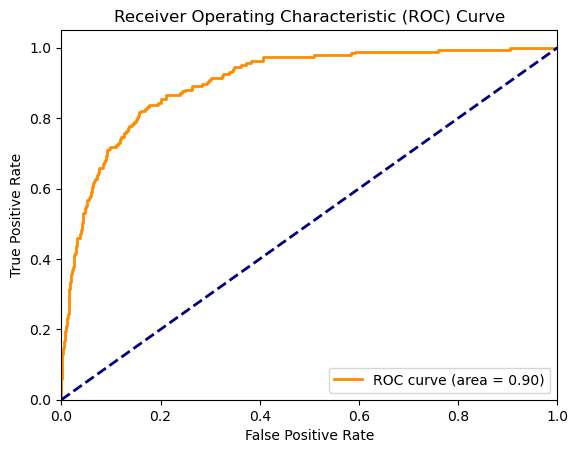

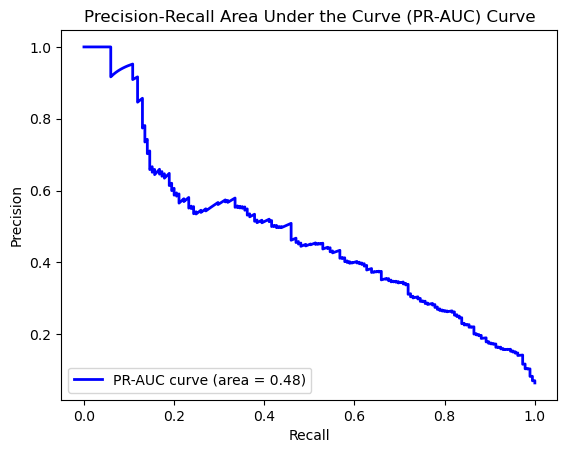

In [20]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

#curva ROC
fpr, tpr, _ = roc_curve(y_test_D, y_pred_test_D)
roc_auc = auc(fpr, tpr)

#curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#curva PR-AUC
precision, recall, _ = precision_recall_curve(y_test_D, y_pred_test_D)
pr_auc = auc(recall, precision)

#curva PR-AUC
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='PR-AUC curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Area Under the Curve (PR-AUC) Curve')
plt.legend(loc="lower left")
plt.show()


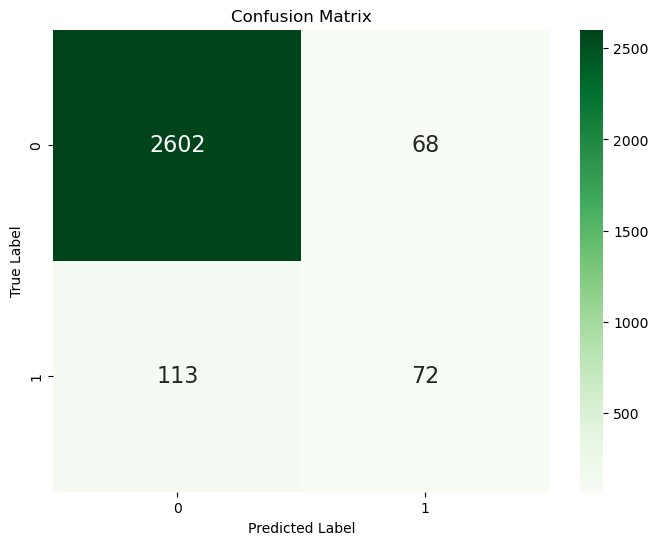

In [38]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

#matriz de confusão
cm = confusion_matrix(y_test_D, (y_pred_test_D > 0.5).astype(int))


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", annot_kws={"size": 16})
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Kiba

### Dataset Loading

In [26]:
kiba= pd.read_csv('/home/resperanca/Projeto/data/KIBA.csv')
kiba= kiba.drop_duplicates()
colunas = ['COMPOUND_SMILES', 'PROTEIN_SEQUENCE', 'REG_LABEL']  # Substitua pelos nomes das colunas que você quer verificar
kiba = kiba.dropna(subset=colunas)
limite = 12
kiba['REG_LABEL'] = kiba['REG_LABEL'].apply(lambda x: 1 if x > limite else 0)
kiba= kiba.sample(frac=1).reset_index(drop=True)
kiba.to_csv('kiba_final.csv', index=False, encoding='utf-8')

In [22]:
kiba= pd.read_csv('/home/resperanca/Projeto/DeepDTA/kiba_final.csv')

In [23]:
#Filtragem por tamanho (proteinas): 

tamanho_proteinas = kiba['PROTEIN_SEQUENCE']
tamanho_proteinas = [len(seq) for seq in tamanho_proteinas]
tamanho_medio_prot = sum(tamanho_proteinas) / len(tamanho_proteinas)


#Filtragem por tamanho (Smiles): 

tamanho_smiles = kiba['COMPOUND_SMILES']
tamanho_smiles = [len(seq) for seq in tamanho_smiles]
tamanho_medio_smiles = sum(tamanho_smiles) / len(tamanho_smiles)


In [25]:
PROT_LEN = 658
SMILE_LEN = 49


def label_smiles(line, MAX_SMI_LEN, CHAR_SMILE_SET):
	X = np.zeros(MAX_SMI_LEN)
	for i, ch in enumerate(line[:MAX_SMI_LEN]): #	x, smi_ch_ind, y
		X[i] = CHAR_SMILE_SET[ch]

	return X #.tolist()

def label_sequence(line, MAX_SEQ_LEN, CHAR_PROT_SET):
	X = np.zeros(MAX_SEQ_LEN)

	for i, ch in enumerate(line[:MAX_SEQ_LEN]):
		X[i] = CHAR_PROT_SET[ch]

	return X #.tolist()

In [26]:
encoded_data_Kiba = {'x_prot':[], 'x_met':[], 'y_train':[]}

for i, (index, row) in enumerate(kiba.iterrows()):
     print('percentage: {0:.3%}'.format(i/kiba.shape[0]), end='\r')
     encoded_data_Kiba ['x_prot'].append(label_sequence(row['PROTEIN_SEQUENCE'], PROT_LEN, CHAR_PROT_SET))
     encoded_data_Kiba ['x_met'].append(label_smiles(row['COMPOUND_SMILES'], SMILE_LEN, CHAR_SMILE_SET))
     encoded_data_Kiba ['y_train'].append(row['REG_LABEL'])



In [27]:
total_samples = 120000

# Calcular os tamanhos para cada conjunto
train_size = int(0.7 * total_samples)
val_size = int(0.15 * total_samples)
test_size = total_samples - train_size - val_size

print(train_size)
print(val_size)
print(test_size)

84000
18000
18000


In [28]:
train_end = train_size
val_end = train_size + val_size

x_prot_k = encoded_data_Kiba['x_prot']
x_met_k = encoded_data_Kiba['x_met']
y_k = encoded_data_Kiba['y_train']

x_prot_train_k = np.array(x_prot_k[:train_size])
x_met_train_k = np.array(x_met_k[:train_size])
y_train_k = np.array(y_k[:train_size])

x_prot_val_k = np.array(x_prot_k[train_end:val_end])
x_met_val_k = np.array(x_met_k[train_end:val_end])
y_val_k = np.array(y_k[train_end:val_end])

x_prot_test_k = np.array(x_prot_k[val_end:])
x_met_test_k = np.array(x_met_k[val_end:])
y_test_k = np.array(y_k[val_end:])

In [29]:
def DeepDTA(PROT_LEN, SMILE_LEN, CHAR_SMI_SET_SIZE, CHAR_PROT_SET_SIZE, NUM_FILTERS):
    X_PROT = Input(shape=(PROT_LEN,), dtype='int32')
    X_MET = Input(shape=(SMILE_LEN,), dtype='int32') ### Buralar flagdan gelmeliii


    ### SMI_EMB_DINMS  FLAGS GELMELII 
    encode_protein = Embedding(input_dim=CHAR_PROT_SET_SIZE, output_dim=128, input_length=PROT_LEN)(X_PROT)
    encode_protein = Conv1D(filters=NUM_FILTERS, kernel_size=4,  activation='relu', padding='valid',  strides=1)(encode_protein)
    encode_protein = Conv1D(filters=NUM_FILTERS*2, kernel_size=8,  activation='relu', padding='valid',  strides=1)(encode_protein)
    encode_protein = Conv1D(filters=NUM_FILTERS*3, kernel_size=12,  activation='relu', padding='valid',  strides=1)(encode_protein)
    encode_protein = GlobalMaxPooling1D()(encode_protein)
    
    encode_smiles = Embedding(input_dim=CHAR_SMI_SET_SIZE, output_dim=128, input_length=SMILE_LEN)(X_MET) 
    encode_smiles = Conv1D(filters=NUM_FILTERS, kernel_size=4,  activation='relu', padding='valid',  strides=1)(encode_smiles)
    encode_smiles = Conv1D(filters=NUM_FILTERS*2, kernel_size=6,  activation='relu', padding='valid',  strides=1)(encode_smiles)
    encode_smiles = Conv1D(filters=NUM_FILTERS*3, kernel_size=8,  activation='relu', padding='valid',  strides=1)(encode_smiles)
    encode_smiles = GlobalMaxPooling1D()(encode_smiles)


    encode_interaction = tf.keras.layers.concatenate([encode_smiles, encode_protein], axis=-1) #merge.Add()([encode_smiles, encode_protein])

    # Fully connected 
    FC1 = Dense(1024, activation='relu')(encode_interaction)
    FC2 = Dropout(0.1)(FC1)
    FC2 = Dense(1024, activation='relu')(FC2)
    FC2 = Dropout(0.1)(FC2)
    FC2 = Dense(512, activation='relu')(FC2)


    # And add a logistic regression on top
    predictions = Dense(1, activation='sigmoid')(FC2) #kernel_initializer='normal"

    interactionModel = Model(inputs=[X_PROT, X_MET], outputs=[predictions])

    interactionModel.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
    print(interactionModel.summary())
    return interactionModel

In [37]:
keras_callbacks_Kiba = [
        EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10),
       ModelCheckpoint('Kiba_checkpoint_clean_dataset.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
]


In [38]:
history_kiba = model.fit([x_prot_train_k, x_met_train_k], 
 						y_train_k,
 						epochs=50, 
 						batch_size=256, 
 						validation_data=([x_prot_val_k, x_met_val_k], y_val_k),
 						callbacks=keras_callbacks_Kiba)

Epoch 1/50
328/329 [============================>.] - ETA: 0s - loss: 0.4541 - accuracy: 0.8050
Epoch 1: val_loss improved from inf to 0.39797, saving model to Kiba_checkpoint_clean_dataset.h5
329/329 [==============================] - 17s 48ms/step - loss: 0.4540 - accuracy: 0.8051 - val_loss: 0.3980 - val_accuracy: 0.8283
Epoch 2/50
  1/329 [..............................] - ETA: 13s - loss: 0.4816 - accuracy: 0.7695

/home/resperanca/miniconda3/envs/biotmpygpu/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


329/329 [==============================] - ETA: 0s - loss: 0.3675 - accuracy: 0.8427
Epoch 2: val_loss improved from 0.39797 to 0.35007, saving model to Kiba_checkpoint_clean_dataset.h5
329/329 [==============================] - 15s 45ms/step - loss: 0.3675 - accuracy: 0.8427 - val_loss: 0.3501 - val_accuracy: 0.8501
Epoch 3/50
329/329 [==============================] - ETA: 0s - loss: 0.3340 - accuracy: 0.8588
Epoch 3: val_loss improved from 0.35007 to 0.33279, saving model to Kiba_checkpoint_clean_dataset.h5
329/329 [==============================] - 15s 45ms/step - loss: 0.3340 - accuracy: 0.8588 - val_loss: 0.3328 - val_accuracy: 0.8579
Epoch 4/50
329/329 [==============================] - ETA: 0s - loss: 0.3150 - accuracy: 0.8669
Epoch 4: val_loss improved from 0.33279 to 0.32435, saving model to Kiba_checkpoint_clean_dataset.h5
329/329 [==============================] - 15s 45ms/step - loss: 0.3150 - accuracy: 0.8669 - val_loss: 0.3244 - val_accuracy: 0.8611
Epoch 5/50
329/329 [=

In [39]:
loss = history_kiba.history['loss']
val_loss = history_kiba.history['val_loss']
acc = history_kiba.history['accuracy']  # Precisão
val_acc = history_kiba.history['val_accuracy']  # Precisão de validação
epochs = range(1, len(loss) + 1)

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Perda de Treinamento')
plt.plot(epochs, val_loss, 'b', label='Perda de Validação')
plt.title('Perda durante o Treinamento e a Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()


plt.show()

In [30]:
model.load_weights('Kiba_checkpoint_clean_dataset.h5')
y_pred_test_k = model.predict([x_prot_test_k, x_met_test_k],verbose=0)

In [31]:
import argparse
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix, cohen_kappa_score, matthews_corrcoef
from tensorflow.keras.models import load_model


def print_metrics(y_test, y_pred_test):
    y_pred_test = y_pred_test[:, 0]

    yhat_classes = np.where(y_pred_test > 0.5, 1, y_pred_test)
    yhat_classes = np.where(yhat_classes < 0.5, 0, yhat_classes).astype(np.int64)
    # accuracy: (tp + tn) / (p + n)
    test_acc = accuracy_score(y_test, yhat_classes)
    print('Accuracy: %f' % test_acc)

    # precision tp / (tp + fp)
    test_prec = precision_score(y_test, yhat_classes)
    print('Precision: %f' % test_prec)

    # recall: tp / (tp + fn)
    test_recall = recall_score(y_test, yhat_classes)
    print('Recall: %f' % test_recall)

    # f1: 2 tp / (2 tp + fp + fn)
    test_f1_score = f1_score(y_test, yhat_classes)
    print('F1 score: %f' % test_f1_score)

    # # ROC AUC
    test_roc_auc = roc_auc_score(y_test, y_pred_test)
    print('ROC AUC: %f' % test_roc_auc)

    # # PR AUC
    test_pr_auc = average_precision_score(y_test, y_pred_test)
    print('PR AUC: %f' % test_pr_auc)

    # kappa
    test_kappa = cohen_kappa_score(y_test, yhat_classes)
    print('Cohens kappa: %f' % test_kappa)

    test_mcc = matthews_corrcoef(y_test, yhat_classes)
    print('MCC: %f' % test_mcc)

    # confusion matrix
    matrix = confusion_matrix(y_test, yhat_classes)
    print('Confusion Matrix:\n %s \n' % matrix)

In [32]:
print_metrics(y_test_k, y_pred_test_k)

Accuracy: 0.882614
Precision: 0.801235
Recall: 0.598443
F1 score: 0.685149
ROC AUC: 0.914277
PR AUC: 0.790927
Cohens kappa: 0.614859
MCC: 0.624749
Confusion Matrix:
 [[12270   515]
 [ 1393  2076]] 



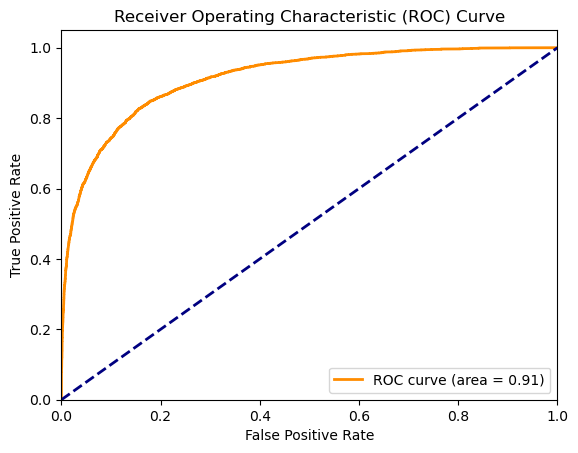

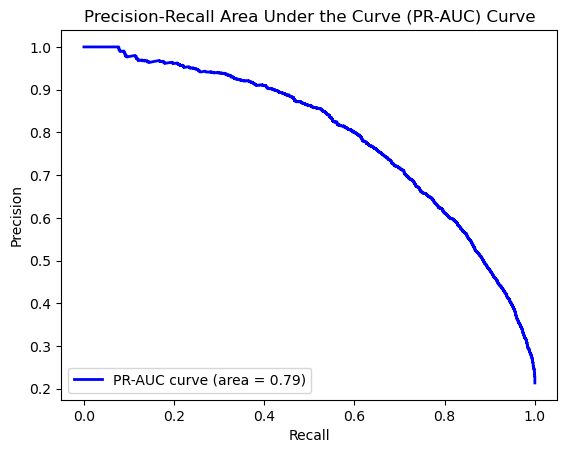

In [34]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

#curva ROC
fpr, tpr, _ = roc_curve(y_test_k, y_pred_test_k)
roc_auc = auc(fpr, tpr)

# Plotando a curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#curva PR-AUC
precision, recall, _ = precision_recall_curve(y_test_k, y_pred_test_k)
pr_auc = auc(recall, precision)

#curva PR-AUC
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='PR-AUC curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Area Under the Curve (PR-AUC) Curve')
plt.legend(loc="lower left")
plt.show()

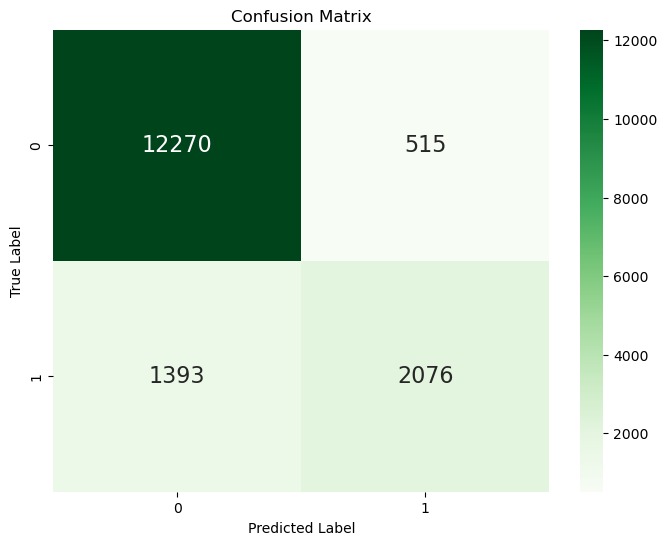

In [39]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# matriz de confusão
cm = confusion_matrix(y_test_k, (y_pred_test_k > 0.5).astype(int))


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", annot_kws={"size": 16})
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## My Dataset 

In [14]:
Davis_final= pd.read_csv('/home/resperanca/Projeto/DeepDTA/Davis_final.csv')
Kiba_final= pd.read_csv('/home/resperanca/Projeto/DeepDTA/kiba_final.csv')

total_samples = 119000

# Calcular os tamanhos para cada conjunto
train_size = int(0.7 * total_samples)
val_size = int(0.15 * total_samples)
test_size = total_samples - train_size - val_size


train_end = train_size
val_end = train_size + val_size

# Junta um embaixo do outro
merged = pd.concat([Davis_final], ignore_index=True)

merged= merged.drop_duplicates()

train_end = train_size
val_end = train_size + val_size

Isoniazid = {
    'COMPOUND_ID': 'CHEMBL64', 
    'PROTEIN_GENE': 'NAN', 
    'PROTEIN_ID': 'P9WIE5', 
    'COMPOUND_SMILES': 'NNC(=O)C1CCNCC1', 
    'PROTEIN_SEQUENCE': 'MPEQHPPITETTTGAASNGCPVVGHMKYPVEGGGNQDWWPNRLNLKVLHQNPAVADPMGAAFDYAAEVATIDVDALTRDIEEVMTTSQPWWPADYGHYGPLFIRMAWHAAGTYRIHDGRGGAGGGMQRFAPLNSWPDNASLDKARRLLWPVKKKYGKKLSWADLIVFAGNCALESMGFKTFGFGFGRVDQWEPDEVYWGKEATWLGDERYSGKRDLENPLAAVQMGLIYVNPEGPNGNPDPMAAAVDIRETFRRMAMNDVETAALIVGGHTFGKTHGAGPADLVGPEPEAAPLEQMGLGWKSSYGTGTGKDAITSGIEVVWTNTPTKWDNSFLEILYGYEWELTKSPAGAWQYTAKDGAGAGTIPDPFGGPGRSPTMLATDLSLRVDPIYERITRRWLEHPEELADEFAKAWYKLIHRDMGPVARYLGPLVPKQTLLWQDPVPAVSHDLVGEAEIASLKSQIRASGLTVSQLVSTAWAAASSFRGSDKRGGANGGRIRLQPQVGWEVNDPDGDLRKVIRTLEEIQESFNSAAPGNIKVSFADLVVLGGCAAIEKAAKAAGHNITVPFTPGRTDASQEQTDVESFAVLEPKADGFRNYLGKGNPLPAEYMLLDKANLLTLSAPEMTVLVGGLRVLGANYKRLPLGVFTEASESLTNDFFVNLLDMGITWEPSPADDGTYQGKDGSGKVKWTGSRVDLVFGSNSELRALVEVYGADDAQPKFVQDFVAAWDKVMNLDRFDVR', 
    'REG_LABEL': '1'
}


Rifampin = {
    'COMPOUND_ID': 'CHEMBL374478', 
    'PROTEIN_GENE': 'NAN', 
    'PROTEIN_ID': 'P9WGY9', 
    'COMPOUND_SMILES': 'CC1C=CC=C(C(=O)NC2=C(C(=C3C(=C2O)C(=C(C4=C3C(=O)C(O4)(OC=CC(C(C(C(C(C(C1O)C)O)C)OC(=O)C)C)OC)C)C)O)O)C=NN5CCN(CC5)C)C', 
    'PROTEIN_SEQUENCE': 'MLEGCILADSRQSKTAASPSPSRPQSSSNNSVPGAPNRVSFAKLREPLEVPGLLDVQTDSFEWLIGSPRWRESAAERGDVNPVGGLEEVLYELSPIEDFSGSMSLSFSDPRFDDVKAPVDECKDKDMTYAAPLFVTAEFINNNTGEIKSQTVFMGDFPMMTEKGTFIINGTERVVVSQLVRSPGVYFDETIDKSTDKTLHSVKVIPSRGAWLEFDVDKRDTVGVRIDRKRRQPVTVLLKALGWTSEQIVERFGFSEIMRSTLEKDNTVGTDEALLDIYRKLRPGEPPTKESAQTLLENLFFKEKRYDLARVGRYKVNKKLGLHVGEPITSSTLTEEDVVATIEYLVRLHEGQTTMTVPGGVEVPVETDDIDHFGNRRLRTVGELIQNQIRVGMSRMERVVRERMTTQDVEAITPQTLINIRPVVAAIKEFFGTSQLSQFMDQNNPLSGLTHKRRLSALGPGGLSRERAGLEVRDVHPSHYGRMCPIETPEGPNIGLIGSLSVYARVNPFGFIETPYRKVVDGVVSDEIVYLTADEEDRHVVAQANSPIDADGRFVEPRVLVRRKAGEVEYVPSSEVDYMDVSPRQMVSVATAMIPFLEHDDANRALMGANMQRQAVPLVRSEAPLVGTGMELRAAIDAGDVVVAEESGVIEEVSADYITVMHDNGTRRTYRMRKFARSNHGTCANQCPIVDAGDRVEAGQVIADGPCTDDGEMALGKNLLVAIMPWEGHNYEDAIILSNRLVEEDVLTSIHIEEHEIDARDTKLGAEEITRDIPNISDEVLADLDERGIVRIGAEVRDGDILVGKVTPKGETELTPEERLLRAIFGEKAREVRDTSLKVPHGESGKVIGIRVFSREDEDELPAGVNELVRVYVAQKRKISDGDKLAGRHGNKGVIGKILPVEDMPFLADGTPVDIILNTHGVPRRMNIGQILETHLGWCAHSGWKVDAAKGVPDWAARLPDELLEAQPNAIVSTPVFDGAQEAELQGLLSCTLPNRDGDVLVDADGKAMLFDGRSGEPFPYPVTVGYMYIMKLHHLVDDKIHARSTGPYSMITQQPLGGKAQFGGQRFGEMECWAMQAYGAAYTLQELLTIKSDDTVGRVKVYEAIVKGENIPEPGIPESFKVLLKELQSLCLNVEVLSSDGAAIELREGEDEDLERAAANLGINLSRNESASVEDLA', 
    'REG_LABEL': '1'
}



Pyrazinamide = {
    'COMPOUND_ID': 'CHEMBL614', 
    'PROTEIN_GENE': 'NAN', 
    'PROTEIN_ID': 'O75469', 
    'COMPOUND_SMILES': 'C1=CN=C(C=N1)C(=O)N', 
    'PROTEIN_SEQUENCE': 'MEVRPKESWNHADFVHCEDTESVPGKPSVNADEEVGGPQICRVCGDKATGYHFNVMTCEGCKGFFRRAMKRNARLRCPFRKGACEITRKTRRQCQACRLRKCLESGMKKEMIMSDEAVEERRALIKRKKSERTGTQPLGVQGLTEEQRMMIRELMDAQMKTFDTTFSHFKNFRLPGVLSSGCELPESLQAPSREEAAKWSQVRKDLCSLKVSLQLRGEDGSVWNYKPPADSGGKEIFSLLPHMADMSTYMFKGIISFAKVISYFRDLPIEDQISLLKGAAFELCQLRFNTVFNAETGTWECGRLSYCLEDTAGGFQQLLLEPMLKFHYMLKKLQLHEEEYVLMQAISLFSPDRPGVLQHRVVDQLQEQFAITLKSYIECNRPQPAHRFLFLKIMAMLTELRSINAQHTQRLLRIQDIHPFATPLMQELFGITGS', 
    'REG_LABEL': '1'
}


Ethambutol = {
    'COMPOUND_ID': 'CHEMBL44884', 
    'PROTEIN_GENE': 'NAN', 
    'PROTEIN_ID': 'P9WNL5', 
    'COMPOUND_SMILES': 'CCC(CO)NCCNC(CC)CO', 
    'PROTEIN_SEQUENCE': 'MATEAAPPRIAVRLPSTSVRDAGANYRIARYVAVVAGLLGAVLAIATPLLPVNQTTAQLNWPQNGTFASVEAPLIGYVATDLNITVPCQAAAGLAGSQNTGKTVLLSTVPKQAPKAVDRGLLLQRANDDLVLVVRNVPLVTAPLSQVLGPTCQRLTFTAHADRVAAEFVGLVQGPNAEHPGAPLRGERSGYDFRPQIVGVFTDLAGPAPPGLSFSASVDTRYSSSPTPLKMAAMILGVALTGAALVALHILDTADGMRHRRFLPARWWSTGGLDTLVIAVLVWWHFVGANTSDDGYILTMARVSEHAGYMAYYRWFGTPEAPFGWYYDLLALWAHVSTASIWMRLPTLAMALTCWWVISREVIPRLGHAVKTSRAAAWTAAGMFLAVWLPLDNGLRPEPIIALGILLTWCSVERAVATSRLLPVAIACIIGALTLFSGPTGIASIGALLVAIGPLRTILHRRSRRFGVLPLVAPILAAATVTAIPIFRDQTFAGEIQANLLKRAVGPSLKWFDEHIRYERLFMASPDGSIARRFAVLALVLALAVSVAMSLRKGRIPGTAAGPSRRIIGITIISFLAMMFTPTKWTHHFGVFAGLAGSLGALAAVAVTGAAMRSRRNRTVFAAVVVFVLALSFASVNGWWYVSNFGVPWSNSFPKWRWSLTTALLELTVLVLLLAAWFHFVANGDGRRTARPTRFRARLAGIVQSPLAIATWLLVLFEVVSLTQAMISQYPAWSVGRSNLQALAGKTCGLAEDVLVELDPNAGMLAPVTAPLADALGAGLSEAFTPNGIPADVTADPVMERPGDRSFLNDDGLITGSEPGTEGGTTAAPGINGSRARLPYNLDPARTPVLGSWRAGVQVPAMLRSGWYRLPTNEQRDRAPLLVVTAAGRFDSREVRLQWATDEQAAAGHHGGSMEFADVGAAPAWRNLRAPLSAIPSTATQVRLVADDQDLAPQHWIALTPPRIPRVRTLQNVVGAADPVFLDWLVGLAFPCQRPFGHQYGVDETPKWRILPDRFGAEANSPVMDHNGGGPLGITELLMRATTVASYLKDDWFRDWGALQRLTPYYPDAQPADLNLGTVTRSGLWSPAPLRRG', 
    'REG_LABEL': '1'
}


Streptomycin = {
    'COMPOUND_ID': 'CHEMBL372795', 
    'PROTEIN_GENE': 'NAN', 
    'PROTEIN_ID': 'Q9UM07', 
    'COMPOUND_SMILES': 'CC1C(C(C(O1)OC2C(C(C(C(C2O)O)N=C(N)N)O)N=C(N)N)OC3C(C(C(C(O3)CO)O)O)NC)(C=O)O', 
    'PROTEIN_SEQUENCE': 'MAQGTLIRVTPEQPTHAVCVLGTLTQLDICSSAPEDCTSFSINASPGVVVDIAHGPPAKKKSTGSSTWPLDPGVEVTLTMKVASGSTGDQKVQISYYGPKTPPVKALLYLTGVEISLCADITRTGKVKPTRAVKDQRTWTWGPCGQGAILLVNCDRDNLESSAMDCEDDEVLDSEDLQDMSLMTLSTKTPKDFFTNHTLVLHVARSEMDKVRVFQATRGKLSSKCSVVLGPKWPSHYLMVPGGKHNMDFYVEALAFPDTDFPGLITLTISLLDTSNLELPEAVVFQDSVVFRVAPWIMTPNTQPPQEVYACSIFENEDFLKSVTTLAMKAKCKLTICPEEENMDDQWMQDEMEIGYIQAPHKTLPVVFDSPRNRGLKEFPIKRVMGPDFGYVTRGPQTGGISGLDSFGNLEVSPPVTVRGKEYPLGRILFGDSCYPSNDSRQMHQALQDFLSAQQVQAPVKLYSDWLSVGHVDEFLSFVPAPDRKGFRLLLASPRSCYKLFQEQQNEGHGEALLFEGIKKKKQQKIKNILSNKTLREHNSFVERCIDWNRELLKRELGLAESDIIDIPQLFKLKEFSKAEAFFPNMVNMLVLGKHLGIPKPFGPVINGRCCLEEKVCSLLEPLGLQCTFINDFFTYHIRHGEVHCGTNVRRKPFSFKWWNMVP', 
    'REG_LABEL': '1'
}



Ethionamide = {
    'COMPOUND_ID': 'CHEMBL1441', 
    'PROTEIN_GENE': 'NAN', 
    'PROTEIN_ID': 'P9WGR1', 
    'COMPOUND_SMILES': 'CCC1=NC=CC(=C1)C(=S)N', 
    'PROTEIN_SEQUENCE': 'MTGLLDGKRILVSGIITDSSIAFHIARVAQEQGAQLVLTGFDRLRLIQRITDRLPAKAPLLELDVQNEEHLASLAGRVTEAIGAGNKLDGVVHSIGFMPQTGMGINPFFDAPYADVSKGIHISAYSYASMAKALLPIMNPGGSIVGMDFDPSRAMPAYNWMTVAKSALESVNRFVAREAGKYGVRSNLVAAGPIRTLAMSAIVGGALGEEAGAQIQLLEEGWDQRAPIGWNMKDATPVAKTVCALLSDWLPATTGDIIYADGGAHTQLL', 
    'REG_LABEL': '1'
}



Kanamycin = {
    'COMPOUND_ID': 'CHEMBL1384', 
    'PROTEIN_GENE': 'NAN', 
    'PROTEIN_ID': 'P0A7S3', 
    'COMPOUND_SMILES': 'C1C(C(C(C(C1N)OC2C(C(C(C(O2)CN)O)O)O)O)OC3C(C(C(C(O3)CO)O)N)O)N', 
    'PROTEIN_SEQUENCE': 'MATVNQLVRKPRARKVAKSNVPALEACPQKRGVCTRVYTTTPKKPNSALRKVCRVRLTNGFEVTSYIGGEGHNLQEHSVILIRGGRVKDLPGVRYHTVRGALDCSGVKDRKQARSKYGVKRPKA', 
    'REG_LABEL': '1'
}



new_row = pd.DataFrame([Isoniazid, Rifampin, Pyrazinamide, Ethambutol, Streptomycin, Ethionamide, Kanamycin ])

merged = pd.concat([merged, new_row], ignore_index=True)

tamanho_proteinas = merged['PROTEIN_SEQUENCE']
tamanho_proteinas = [len(seq) for seq in tamanho_proteinas]
tamanho_medio_prot = sum(tamanho_proteinas) / len(tamanho_proteinas)

tamanho_smiles = merged['COMPOUND_SMILES']
tamanho_smiles = [len(seq) for seq in tamanho_smiles]
tamanho_medio_smiles = sum(tamanho_smiles) / len(tamanho_smiles)

PROT_LEN = 703
SMILE_LEN = 60


def label_smiles(line, MAX_SMI_LEN, CHAR_SMILE_SET):
	X = np.zeros(MAX_SMI_LEN)
	for i, ch in enumerate(line[:MAX_SMI_LEN]): #	x, smi_ch_ind, y
		X[i] = CHAR_SMILE_SET[ch]

	return X #.tolist()

def label_sequence(line, MAX_SEQ_LEN, CHAR_PROT_SET):
	X = np.zeros(MAX_SEQ_LEN)

	for i, ch in enumerate(line[:MAX_SEQ_LEN]):
		X[i] = CHAR_PROT_SET[ch]

	return X #.tolist()

encoded_data_merged= {'x_prot':[], 'x_met':[], 'y_train':[]}

for i, (index, row) in enumerate(merged.iterrows()):
     print('percentage: {0:.3%}'.format(i/merged.shape[0]), end='\r')
     encoded_data_merged['x_prot'].append(label_sequence(row['PROTEIN_SEQUENCE'], PROT_LEN, CHAR_PROT_SET))
     encoded_data_merged['x_met'].append(label_smiles(row['COMPOUND_SMILES'], SMILE_LEN, CHAR_SMILE_SET))
     encoded_data_merged['y_train'].append(row['REG_LABEL'])
     



In [15]:
x_prot_M = encoded_data_merged['x_prot']
x_met_M = encoded_data_merged['x_met']
y_M = encoded_data_merged['y_train']


x_prot_test_M = np.array(x_prot_M)
x_met_test_M = np.array(x_met_M)
y_test_M = np.array(y_M)

In [18]:
model.load_weights('Kiba_checkpoint_clean_dataset.h5')
y_pred_test_M = model.predict([x_prot_test_M, x_met_test_M],verbose=0)

array([[0.00135985],
       [0.01153979],
       [0.02400718],
       ...,
       [0.02753717],
       [0.01104202],
       [0.0077088 ]], dtype=float32)

# Matrizes

In [20]:
drug_column = 'COMPOUND_ID'
target_column = 'PROTEIN_ID'

drogas_test = merged[drug_column]
proteinas_test = merged[target_column]
valores_previsoes = y_pred_test_M.flatten() 


In [21]:
import pandas as pd

data = {'Drug': drogas_test, 'Protein': proteinas_test, 'Prediction': valores_previsoes}
df = pd.DataFrame(data)

# Construir a matriz de interação droga-alvo usando pivot_table
interaction_matrix_D = df.pivot_table(index='Drug', columns='Protein', values='Prediction', aggfunc='first')

interaction_matrix_D = interaction_matrix_D.fillna(0)

# Mostrar a matriz de interação
print("\nMatriz de interação droga-alvo:")
print(interaction_matrix_D)



Matriz de interação droga-alvo:
Protein       A0A091FTP9  A0A2K5TT62  A0A6D2XP67  A0A6D2Y6E9    A1R9W2  \
Drug                                                                     
5291            0.181057    0.927649    0.783233    0.707933  0.745425   
44259           0.667160    0.996679    0.990729    0.977991  0.952003   
123631          0.000017    0.025327    0.015022    0.000085  0.002091   
126565          0.999879    0.997876    0.999399    1.000000  0.756867   
151194          0.000744    0.221544    0.085352    0.004410  0.026248   
...                  ...         ...         ...         ...       ...   
CHEMBL372795    0.000000    0.000000    0.000000    0.000000  0.000000   
CHEMBL374478    0.000000    0.000000    0.000000    0.000000  0.000000   
CHEMBL44884     0.000000    0.000000    0.000000    0.000000  0.000000   
CHEMBL614       0.000000    0.000000    0.000000    0.000000  0.000000   
CHEMBL64        0.000000    0.000000    0.000000    0.000000  0.000000   

Prot

In [25]:
id_procurado = 'CHEMBL64'
linha = interaction_matrix_D.loc[id_procurado]
print(linha)


Valores correspondentes ao ID procurado:
Protein
A0A091FTP9    0.000000
A0A2K5TT62    0.000000
A0A6D2XP67    0.000000
A0A6D2Y6E9    0.000000
A1R9W2        0.000000
A4VCI5        0.000000
B3KS12        0.000000
E9PUP9        0.000000
L7RXH5        0.000000
O00238        0.000000
O00329        0.000000
O00444        0.000000
O00506        0.000000
O00750        0.000000
O14578        0.000000
O14730        0.000000
O14733        0.000000
O14757        0.000000
O14920        0.000000
O14936        0.000000
O14965        0.000000
O14976        0.000000
O15075        0.000000
O15111        0.000000
O15146        0.000000
O15197        0.000000
O15264        0.000000
O15530        0.000000
O43283        0.000000
O43293        0.000000
O43318        0.000000
O43353        0.000000
O60285        0.000000
O60331        0.000000
O75385        0.000000
O75460        0.000000
O75469        0.000000
O75716        0.000000
O75747        0.000000
O75914        0.000000
O94768        0.000000
O94804  